# Yolov3 Object Detection

## 设置数据集

请将数据集压缩包上传到Image文件夹下，上传完成后执行下面的代码解压文件。
确保解压后的Image目录下的结构如下：

|Image

|—VOCdevkit

|——VOC2007(具体数据集文件夹名称)

|————Annotations

        └─  *.xml # 存放图片的类别与边框

|————JPEGImages

        └─ *.jpg # 存放图片

|————ImageSets

|——————Main

            └─ *.txt # 存放训练集、验证集所用图片名称，包括train.txt,val.txt其中包含了图片的文件名，图片分别用于训练和验证，没有交集

### 解压数据集

In [3]:
#unzip *.zip
import os
os.chdir('Image')#工作目录转到Image文件夹下
#下载测试用数据集
#!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#解压数据集
#!tar xf VOCtrainval_06-Nov-2007.tar
!ls

VOCdevkit  VOCtrainval_06-Nov-2007.tar


### 设置数据集参数

In [4]:
#请修改文件夹名称
imagefolder = 'VOC2007'

In [5]:
#请修改类别名称
classnames = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

## 标签格式转换

执行如下代码，将会在VOC目录下产生`train.txt`和`val.txt`文件，其中内容为图片的绝对路径。

In [6]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

sets=[(imagefolder, 'train'), (imagefolder, 'val')]

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(foldername, image_id):
    in_file = open('VOCdevkit/%s/Annotations/%s.xml'%(foldername, image_id))
    out_file = open('VOCdevkit/%s/labels/%s.txt'%(foldername, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classnames or int(difficult) == 1:
            continue
        cls_id = classnames.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for foldername, image_set in sets:
    if not os.path.exists('VOCdevkit/%s/labels/'%(foldername)):
        os.makedirs('VOCdevkit/%s/labels/'%(foldername))
    image_ids = open('VOCdevkit/%s/ImageSets/Main/%s.txt'%(foldername, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(foldername, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/%s/JPEGImages/%s.jpg\n'%(wd, foldername, image_id))
        convert_annotation(foldername, image_id)
    list_file.close()

#### 查看生成的文件

In [7]:
!ls

VOC2007_train.txt  VOC2007_val.txt  VOCdevkit  VOCtrainval_06-Nov-2007.tar


## 基础参数设置

数据集信息配置

In [8]:
#cfg/voc.data
classes= len(classnames)
train  = '/home/jxm/msfthack/Image/' + foldername + '_train.txt'
valid  = '/home/jxm/msfthack/Image/' + foldername + '_val.txt'
names = 'data/voc.names'
backup = 'backup'
vocdata=['classes = '+ str(classes), 'train = '+ train, 'valid = '+ valid, 'names = '+ names, 'backup = '+backup]

In [9]:
vocdata

['classes = 20',
 'train = /home/jxm/msfthack/Image/VOC2007_train.txt',
 'valid = /home/jxm/msfthack/Image/VOC2007_val.txt',
 'names = data/voc.names',
 'backup = backup']

In [10]:
vocdatafilepath = '/home/jxm/msfthack/darknet/cfg/voc.data'
for i in range(len(vocdata)):
    vocdata[i] = vocdata[i] +'\n'
with open(vocdatafilepath,'w') as f:
    f.writelines(vocdata)

In [11]:
vocnamesfilepath = '/home/jxm/msfthack/darknet/data/voc.names'
with open(vocnamesfilepath,'w') as f:
    for item in classnames:
        f.write(item+'\n')

## 训练参数设置

请在训练时将batch和subdivisions设置成不为1的值，测试时使两个值均为1

In [12]:
#请修改下面两行
batch = 64
subdivisions = 16
#filers请勿修改
filters = (classes + 5) * 3

In [14]:
voccfgfilepath = '/home/jxm/msfthack/darknet/cfg/yolov3-voc.cfg'
lines = []
with open(voccfgfilepath,'r') as f:
    lines = f.readlines()
    
if batch != 1 and subdivisions != 1:
    lines[2] = '# batch=1\n'
    lines[3] = '# subdivisions=1\n'
    lines[5] = 'batch=' + str(batch) +'\n'
    lines[6] = 'subdivisions=' + str(subdivisions) +'\n'
else:
    lines[2] = 'batch=1\n'
    lines[3] = 'subdivisions=1\n'
    lines[5] = '# '+ lines[5]
    lines[6] = '# '+ lines[6]
for i in range(len(lines)):
    if lines[i] == '[yolo]\n':
        lines[i-3] = 'filters='+ str(filters) + '\n'
        lines[i+3] = 'classes='+ str(classes) + '\n'
        
with open(voccfgfilepath,'w') as f:
    f.writelines(lines)

## 开始训练

下载预训练模型

In [15]:
#切换工作目录至darknet
os.chdir('/home/jxm/msfthack/darknet')

In [27]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2018-07-08 14:03:22--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com... 128.208.3.39
Connecting to pjreddie.com|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  38.5MB/s    in 4.5s    

2018-07-08 14:03:27 (34.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



下面开始训练命令，这一过程时间较长，请观察输出的损失值,例如

> 8: 1681.814209, 1683.156128 avg loss, 0.000000 rate, 19.733069 seconds, 512 images

这里的loss在1681，在loss降低到0.0XXX时可手动终止。开始时损失值较大，后面会收敛到比较小的值。

如果有多个GPU,请修改gpus参数，例如 -gpus 0,1,2,3

In [17]:
!./darknet detector train cfg/voc.data cfg/yolov3-voc.cfg darknet53.conv.74 -gpus 0

0
yolov3-voc
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.

Region 82 Avg IOU: 0.408930, Class: 0.587675, Obj: 0.428096, No Obj: 0.431491, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.297803, Class: 0.602012, Obj: 0.483301, No Obj: 0.553737, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505394, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.237788, Class: 0.470691, Obj: 0.419177, No Obj: 0.431979, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.137762, Class: 0.392039, Obj: 0.678148, No Obj: 0.554493, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505550, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.469444, Class: 0.509075, Obj: 0.300621, No Obj: 0.431194, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.301247, Class: 0.547224, Obj: 0.514097, No Obj: 0.554816, .5R: 0.142857, .75R: 0.000000,  count: 14
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505786, .5R: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554698, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505817, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.451456, Class: 0.495153, Obj: 0.440636, No Obj: 0.431906, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.593522, Class: 0.519199, Obj: 0.415588, No Obj: 0.553930, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505751, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.466708, Class: 0.477638, Obj: 0.469488, No Obj: 0.431210, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.553930, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505522, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.533746, Class: 0.488309, Obj: 0.427295, No Obj: 0.431277, .5R: 0.666667, .75R: 0.111111,  count: 9
Region 94 Avg IOU

Region 82 Avg IOU: 0.394293, Class: 0.498639, Obj: 0.567204, No Obj: 0.431736, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.154713, Class: 0.538788, Obj: 0.566767, No Obj: 0.554402, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505092, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.445610, Class: 0.360451, Obj: 0.493876, No Obj: 0.431991, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.524108, Class: 0.299291, Obj: 0.584455, No Obj: 0.554803, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505732, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429524, Class: 0.470728, Obj: 0.371449, No Obj: 0.431096, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.204384, Class: 0.328417, Obj: 0.541609, No Obj: 0.554493, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.028467, Class: 0.419807, Obj: 0.385204, No Obj: 0.505595

Region 82 Avg IOU: 0.457373, Class: 0.548877, Obj: 0.546215, No Obj: 0.431476, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.274348, Class: 0.438605, Obj: 0.522628, No Obj: 0.554328, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505540, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.356278, Class: 0.545684, Obj: 0.304770, No Obj: 0.430525, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.357818, Class: 0.534595, Obj: 0.662632, No Obj: 0.554432, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505773, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.338839, Class: 0.551772, Obj: 0.440881, No Obj: 0.430677, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.127633, Class: 0.516229, Obj: 0.480271, No Obj: 0.554259, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505193, .5R: -nan,

Region 94 Avg IOU: 0.143261, Class: 0.533366, Obj: 0.630506, No Obj: 0.554366, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505817, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.291004, Class: 0.430713, Obj: 0.410667, No Obj: 0.431825, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.086710, Class: 0.185212, Obj: 0.399417, No Obj: 0.554471, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505417, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.349045, Class: 0.635051, Obj: 0.414943, No Obj: 0.430493, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.240223, Class: 0.491916, Obj: 0.593720, No Obj: 0.554240, .5R: 0.071429, .75R: 0.000000,  count: 14
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505800, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.248161, Class: 0.453322, Obj: 0.403344, No Obj: 0.431164, .5R: 0.000000, .7

Region 82 Avg IOU: 0.414936, Class: 0.579163, Obj: 0.403651, No Obj: 0.431756, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.340913, Class: 0.345528, Obj: 0.604993, No Obj: 0.554335, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505786, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483159, Class: 0.450354, Obj: 0.402770, No Obj: 0.430760, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.242026, Class: 0.573642, Obj: 0.540870, No Obj: 0.554480, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.198525, Class: 0.458227, Obj: 0.382492, No Obj: 0.505360, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.496827, Class: 0.549665, Obj: 0.341295, No Obj: 0.430498, .5R: 0.600000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.385829, Class: 0.555577, Obj: 0.625562, No Obj: 0.554551, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

## 模型指标评估

In [29]:
#查看训练保存的模型
!ls backup

yolov3-voc_1000.weights  yolov3-voc_1900.weights  yolov3-voc_2800.weights
yolov3-voc_100.weights	 yolov3-voc_2000.weights  yolov3-voc_2900.weights
yolov3-voc_1100.weights  yolov3-voc_200.weights   yolov3-voc_3000.weights
yolov3-voc_1200.weights  yolov3-voc_2100.weights  yolov3-voc_300.weights
yolov3-voc_1300.weights  yolov3-voc_2200.weights  yolov3-voc_400.weights
yolov3-voc_1400.weights  yolov3-voc_2300.weights  yolov3-voc_500.weights
yolov3-voc_1500.weights  yolov3-voc_2400.weights  yolov3-voc_600.weights
yolov3-voc_1600.weights  yolov3-voc_2500.weights  yolov3-voc_700.weights
yolov3-voc_1700.weights  yolov3-voc_2600.weights  yolov3-voc_800.weights
yolov3-voc_1800.weights  yolov3-voc_2700.weights  yolov3-voc_900.weights


**测试前请回到前面参数设置步骤的两个单元格，将batch和subdivisions设置为1**

In [53]:
!./darknet detector valid cfg/voc.data cfg/yolov3-voc.cfg backup/yolov3-voc_3000.weights

results: Using default 'results'
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   -> 

1260
1264
1268
1272
1276
1280
1284
1288
1292
1296
1300
1304
1308
1312
1316
1320
1324
1328
1332
1336
1340
1344
1348
1352
1356
1360
1364
1368
1372
1376
1380
1384
1388
1392
1396
1400
1404
1408
1412
1416
1420
1424
1428
1432
1436
1440
1444
1448
1452
1456
1460
1464
1468
1472
1476
1480
1484
1488
1492
1496
1500
1504
1508
1512
1516
1520
1524
1528
1532
1536
1540
1544
1548
1552
1556
1560
1564
1568
1572
1576
1580
1584
1588
1592
1596
1600
1604
1608
1612
1616
1620
1624
1628
1632
1636
1640
1644
1648
1652
1656
1660
1664
1668
1672
1676
1680
1684
1688
1692
1696
1700
1704
1708
1712
1716
1720
1724
1728
1732
1736
1740
1744
1748
1752
1756
1760
1764
1768
1772
1776
1780
1784
1788
1792
1796
1800
1804
1808
1812
1816
1820
1824
1828
1832
1836
1840
1844
1848
1852
1856
1860
1864
1868
1872
1876
1880
1884
1888
1892
1896
1900
1904
1908
1912
1916
1920
1924
1928
1932
1936
1940
1944
1948
1952
1956
1960
1964
1968
1972
1976
1980
1984
1988
1992
1996
2000
2004
2008
2012
2016
2020
2024
2028
2032
2036
2040
2044
2048
2052
2056


In [18]:
#查看验证输出文件
!ls -lh results/

total 2.0M
-rw-rw-r-- 1 jxm jxm  33K Jul  9 02:23 comp4_det_test_aeroplane.txt
-rw-rw-r-- 1 jxm jxm  50K Jul  9 02:23 comp4_det_test_bicycle.txt
-rw-rw-r-- 1 jxm jxm  64K Jul  9 02:23 comp4_det_test_bird.txt
-rw-rw-r-- 1 jxm jxm  43K Jul  9 02:23 comp4_det_test_boat.txt
-rw-rw-r-- 1 jxm jxm  77K Jul  9 02:23 comp4_det_test_bottle.txt
-rw-rw-r-- 1 jxm jxm  33K Jul  9 02:23 comp4_det_test_bus.txt
-rw-rw-r-- 1 jxm jxm 142K Jul  9 02:23 comp4_det_test_car.txt
-rw-rw-r-- 1 jxm jxm  56K Jul  9 02:23 comp4_det_test_cat.txt
-rw-rw-r-- 1 jxm jxm 146K Jul  9 02:23 comp4_det_test_chair.txt
-rw-rw-r-- 1 jxm jxm  50K Jul  9 02:23 comp4_det_test_cow.txt
-rw-rw-r-- 1 jxm jxm  32K Jul  9 02:23 comp4_det_test_diningtable.txt
-rw-rw-r-- 1 jxm jxm  91K Jul  9 02:23 comp4_det_test_dog.txt
-rw-rw-r-- 1 jxm jxm  67K Jul  9 02:23 comp4_det_test_horse.txt
-rw-rw-r-- 1 jxm jxm  77K Jul  9 02:23 comp4_det_test_motorbike.txt
-rw-rw-r-- 1 jxm jxm 632K Jul  9 02:23 comp4_det_test_person.txt
-rw-rw-r-- 1 jxm jxm  7

统计每个类型的准确率

In [19]:
import xml.etree.ElementTree as ET
import os
import pickle
import numpy as np


def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        #obj_struct['truncated'] = int(obj.find('truncated').text)
        #obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])
    Top level function that does the PASCAL VOC evaluation.
    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images 获取图像文件路径
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]
# recs所有框
    recs = {}
    if not os.path.isfile(cachefile):
        # load annots
        for i, imagename in enumerate(imagenames):
            recs[imagename[-10:-4]
                 ] = parse_rec(annopath.format(imagename[-10:-4]))
            # recs[imagename] = parse_rec(annopath.format(imagename))
            #print(
            #    'Reading annotation for {:d}/{:d}'.format(i + 1, len(imagenames)))

    # extract gt objects for this class
    # 获得ground truth
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename[-10:-4]] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([0]*len(R)).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename[-10:-4]
                   ] = {'bbox': bbox, 'difficult': difficult, 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
# 读取预测值
    splitlines = [x.strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]]
                   for x in splitlines])  # 获得bonding box
# sort by confidence
    sorted_ind = np.argsort(-confidence)  # 按置信度索引 从高到低
    sorted_scores = np.sort(-confidence)  # 置信度从高到低
    BB = BB[sorted_ind, :]  # 把bonding box按其置信度从高到低排列
    image_ids = [image_ids[x] for x in sorted_ind]  # 把对应图片从高到低

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)  # true positive
    fp = np.zeros(nd)  # false positive
    for d in range(nd):
        R = class_recs[image_ids[d]]  # 获得对应图片ground truth所有数据
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)  # 获得bonding box ground truth

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)  # 找到最大的iou
            jmax = np.argmax(overlaps)  # 第几个iou最大
# 如果iou>阈值
        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap
aplist=[]
for item in classnames:
    resultfilename = '/home/jxm/msfthack/darknet/results/comp4_det_test_'+ item + '.txt'
    rec, prec, ap = voc_eval(resultfilename, '/home/jxm/msfthack/Image/VOCdevkit/' + imagefolder +'/Annotations/{}.xml',
                         '/home/jxm/msfthack/Image/' + imagefolder + '_val.txt', item, '.')
    print('%s ap=%f' % (item, ap.tolist()))
    aplist.append(ap.tolist())

aeroplane ap=0.627032
bicycle ap=0.564327
bird ap=0.397420
boat ap=0.282893
bottle ap=0.322431
bus ap=0.522193
car ap=0.601255
cat ap=0.757717
chair ap=0.277732
cow ap=0.444172
diningtable ap=0.270853
dog ap=0.636824
horse ap=0.690987
motorbike ap=0.603820
person ap=0.613856
pottedplant ap=0.199216
sheep ap=0.416267
sofa ap=0.419765
train ap=0.675802
tvmonitor ap=0.548038


#### 计算mAP

In [20]:
np.mean(aplist)

0.4936299151623074

## 单张图片测试

请在命令最后设置需要测试的图片路径。

将路径 /home/jxm/msfthack/Image/VOCdevkit/VOC2007/JPEGImages/000220.jpg
改为实际需要测试的图片绝对路径

In [64]:
!./darknet detector test cfg/voc.data cfg/yolov3-voc.cfg backup/yolov3-voc_3000.weights /home/jxm/msfthack/Image/VOCdevkit/VOC2007/JPEGImages/000220.jpg

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [12]:
import matplotlib.pyplot as plt
def plot_image(imgpath):
    img = plt.imread(imgpath)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    #img.set_size_inches(2,2)
    plt.imshow(img)
    plt.show()

####  对比原始图片和检测结果

In [2]:
testimagepath = '/home/jxm/msfthack/Image/VOCdevkit/VOC2007/JPEGImages/000220.jpg'

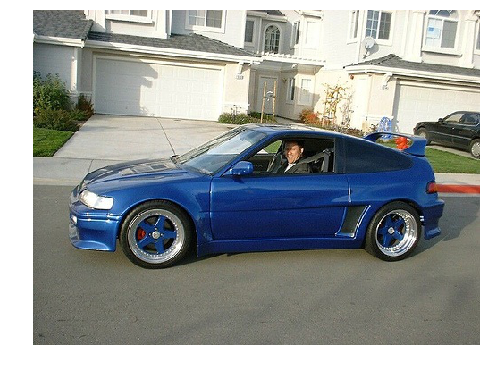

In [13]:
plot_image(testimagepath)

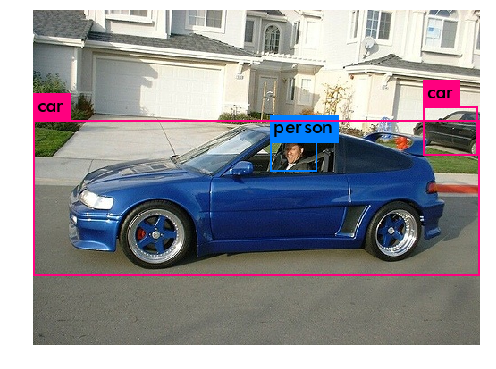

In [14]:
plot_image('/home/jxm/msfthack/darknet/predictions.png')

### 转移模型文件

In [63]:
!mkdir /home/jxm/msfthack/Image/VOCdevkit/weights
!mv /home/jxm/msfthack/darknet/backup/* /home/jxm/msfthack/Image/VOCdevkit/weights/

请到Image/VOCdevkit文件夹下的weights文件夹中下载模型文件。模型尾数为训练轮数，一定程度上尾数越大，模型越好。